In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import anndata as ad

In [2]:
data_path = Path("../Data/STDS0000002/unprocessed")
files = sorted(data_path.glob("A*_10xvisium.h5ad"))

print(f"Found {len(files)} files:")
for f in files:
    print(f.name)

Found 8 files:
A1_10xvisium.h5ad
A2_10xvisium.h5ad
A3_10xvisium.h5ad
A4_10xvisium.h5ad
A6_10xvisium.h5ad
A7_10xvisium.h5ad
A8_10xvisium.h5ad
A9_10xvisium.h5ad


In [3]:
adatas = []
for f in files:
    print(f"Loading: {f.name}")
    adata = sc.read_h5ad(f)  # should now succeed for all
    adata.obs["sample"] = f.stem.split("-")[0]
    adatas.append(adata)

# Merge into one AnnData object
adata = ad.concat(adatas, label="section", keys=[a.obs["sample"][0] for a in adatas])
print("Merged AnnData:", adata)
adata.write("../Data/STDS0000002/adata_processed.h5ad")

Loading: A1_10xvisium.h5ad
Loading: A2_10xvisium.h5ad
Loading: A3_10xvisium.h5ad
Loading: A4_10xvisium.h5ad
Loading: A6_10xvisium.h5ad
Loading: A7_10xvisium.h5ad
Loading: A8_10xvisium.h5ad
Loading: A9_10xvisium.h5ad


/var/folders/mb/b_x6s7gj5p765n_c33q22x0r0000gn/T/ipykernel_58449/3634851536.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata = ad.concat(adatas, label="section", keys=[a.obs["sample"][0] for a in adatas])
/Users/bilalkachir/Desktop/Internship/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Merged AnnData: AnnData object with n_obs × n_vars = 39936 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'section'
    obsm: 'spatial'


In [4]:
print(adata)
print(adata.X)        # the raw gene expression count matrix
print(adata.X.toarray())  # peek at first 5 spots × 5 genes
print(adata.var_names[:5])       # gene IDs (columns of adata.X)
print(adata.obs_names[:5])      # spot/barcode IDs (rows of adata.X)
print(adata.obsm["spatial"][:5])   # first 5 spot coordinates (X, Y)
n_spots = adata.n_obs
n_genes = adata.n_vars
print(f"Dataset has {n_genes:,} genes and {n_spots:,} spots.")


AnnData object with n_obs × n_vars = 39936 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'section'
    obsm: 'spatial'
<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 45168493 stored elements and shape (39936, 33538)>
  Coords	Values
  (0, 48)	1.0
  (0, 736)	1.0
  (0, 918)	1.0
  (0, 1038)	1.0
  (0, 1064)	1.0
  (0, 1192)	1.0
  (0, 1329)	1.0
  (0, 1571)	1.0
  (0, 1931)	2.0
  (0, 2003)	1.0
  (0, 2072)	1.0
  (0, 2139)	1.0
  (0, 2176)	1.0
  (0, 2650)	1.0
  (0, 2677)	1.0
  (0, 3210)	2.0
  (0, 3396)	1.0
  (0, 3482)	1.0
  (0, 3784)	1.0
  (0, 3834)	1.0
  (0, 4018)	2.0
  (0, 4026)	1.0
  (0, 4295)	1.0
  (0, 5072)	1.0
  (0, 5148)	1.0
  :	:
  (39935, 33211)	1.0
  (39935, 33224)	1.0
  (39935, 33244)	1.0
  (39935, 33258)	1.0
  (39935, 33277)	1.0
  (39935, 33279)	1.0
  (39935, 33297)	3.0
  (39935, 33327)	1.0
  (39935, 33362)	1.0
  (39935, 33375)	1.0
  (39935, 33379)	2.0
  (39935, 33394)	2.0
  (39935, 33397)	1.0
  (39935, 33412)	1.0
  (39935, 33445)	1.0
  (39935, 33474

## Dataset Overview — STDS0000002

### 1. Gene Expression Storage

- Gene expression values are stored in **`adata.X`**.
- It is a **compressed sparse row (CSR) matrix** of shape **(39,936 × 33,538)**:
  ```
  <Compressed Sparse Row sparse matrix of dtype 'float32'
   with 45,168,493 stored elements and shape (39936, 33538)>
  ```
- Each **row** represents a tissue **spot/barcode**, and each **column** corresponds to a **gene**.
- To view a portion of the matrix:
  ```python
  adata.X[:5, :5].toarray()
  ```

---

### 2. Spatial Coordinates of Spots

- The spatial coordinates are stored in:
  ```python
  adata.obsm["spatial"]
  ```
- This is a NumPy array of shape **(39,936 × 2)** — one `[x, y]` coordinate pair per spot.
- These represent the physical location of each spot on the tissue slide.
- Example:
  ```python
  adata.obsm["spatial"][:5]
  ```

---

### 3. Dataset Dimensions

- **Number of spots (observations):** `39,936`
- **Number of genes (features):** `33,538`

Check with:
```python
print(f"Dataset has {adata.n_vars:,} genes and {adata.n_obs:,} spots.")
```

---



In [5]:
from scipy.sparse import issparse

# Get dense matrix for calculation (safely handle sparse or dense)
X = adata.X.toarray() if issparse(adata.X) else adata.X

# Compute mean and variance across spots (rows)
gene_means = X.mean(axis=0)
gene_vars = X.var(axis=0)

# Gene names
gene_names = adata.var_names

# Create DataFrames with rankings
mean_rank = pd.DataFrame({
    "gene": gene_names,
    "mean_expression": gene_means
}).sort_values(by="mean_expression", ascending=False).reset_index(drop=True)

var_rank = pd.DataFrame({
    "gene": gene_names,
    "variance": gene_vars
}).sort_values(by="variance", ascending=False).reset_index(drop=True)

In [6]:
# Save to CSV
mean_rank.to_csv("../Data/STDS0000002/gene_ranking_by_mean.csv", index=False)
var_rank.to_csv("../Data/STDS0000002/gene_ranking_by_variance.csv", index=False)

In [7]:
print("Top genes by mean expression:")
print(mean_rank.head())

print("\nTop genes by variance:")
print(var_rank.head())

Top genes by mean expression:
     gene  mean_expression
0  MT-CO2        24.845654
1  MT-CO3        21.380234
2  EEF1A1        19.966671
3  MT-CO1        16.050455
4   RPL41        13.101888

Top genes by variance:
     gene     variance
0  MT-CO2  3708.890137
1  MT-CO3  1903.877197
2  MT-CO1  1738.385864
3  EEF1A1  1356.804321
4  COL3A1  1028.573364


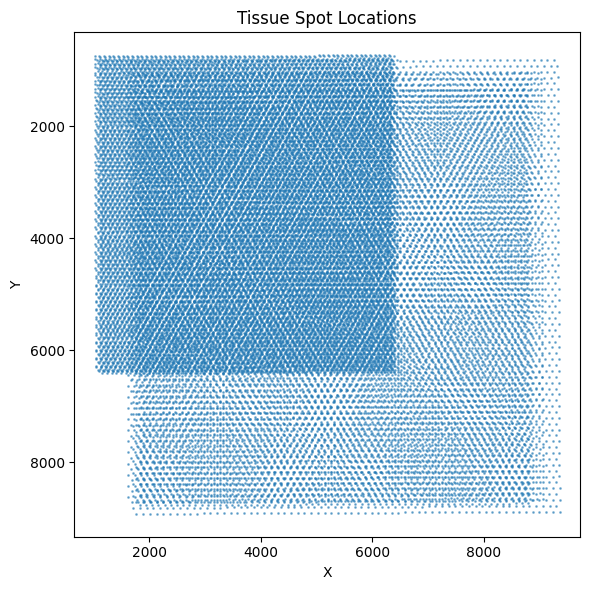

In [22]:
# Scatterplot of tissue coordinates
# Extract spatial coordinates
coords = adata.obsm["spatial"]

# Create a boolean mask for spots with total counts > 0
if hasattr(adata.X, "sum"):  # supports sparse or dense
    total_counts = adata.X.sum(axis=1)
    total_counts = total_counts.A1 if hasattr(total_counts, "A1") else total_counts.flatten()
else:
    total_counts = np.array(adata.X).sum(axis=1)

nonzero_mask = total_counts > 0

# Now apply mask safely
coords_filtered = coords[nonzero_mask]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(coords_filtered[:, 0], coords_filtered[:, 1], s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.title("Tissue Spot Locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.tight_layout()
plt.show()


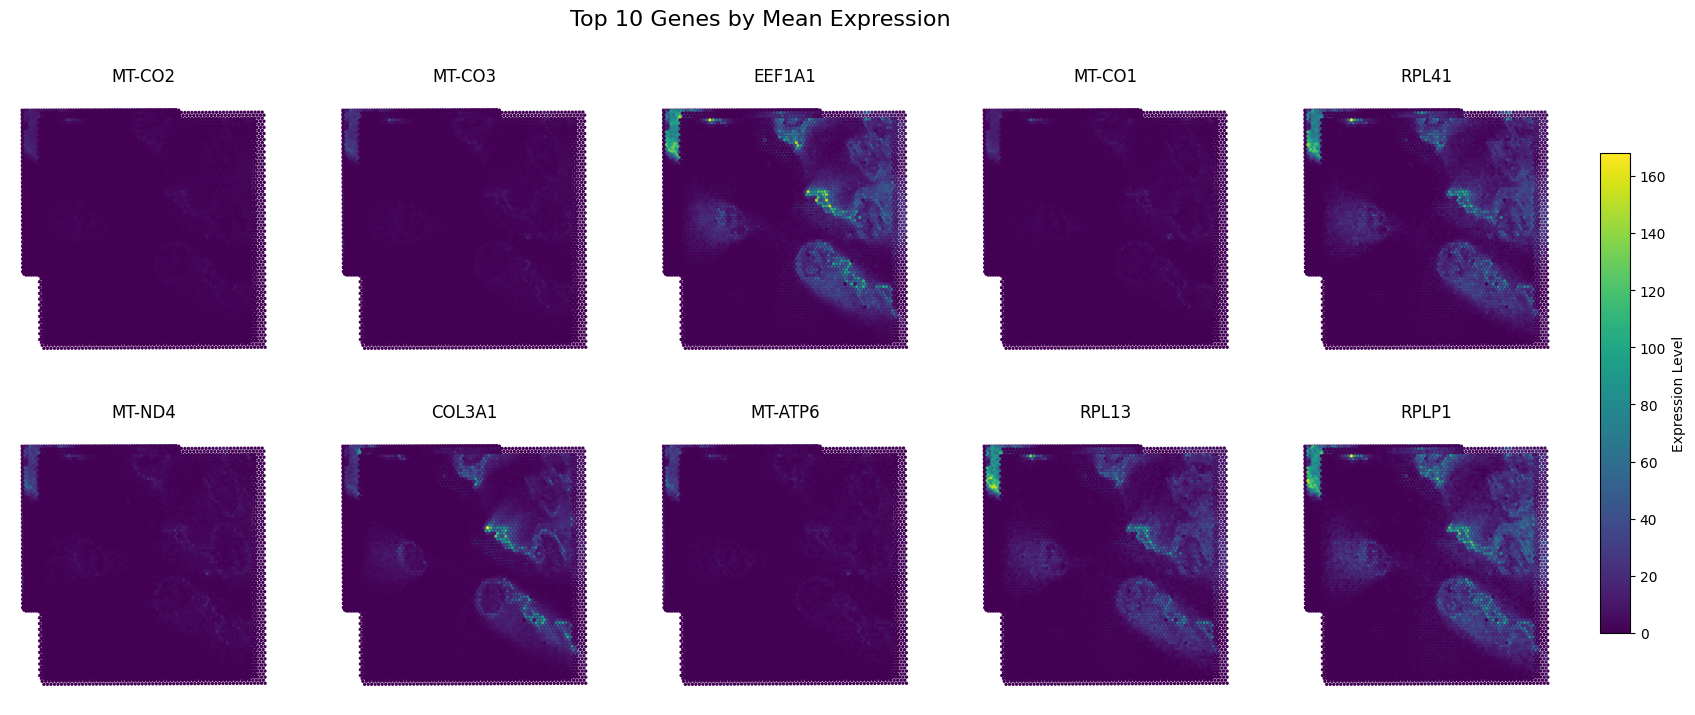

In [30]:
# Setup: 2 rows × 5 columns grid
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Coordinates and mask
coords = adata.obsm["spatial"]
total_counts = adata.X.sum(axis=1)
total_counts = total_counts.A1 if hasattr(total_counts, "A1") else total_counts.flatten()
nonzero_mask = total_counts > 0
coords_filtered = coords[nonzero_mask]

# Plot each gene in its subplot
for i, gene in enumerate(top_genes):
    ax = axes[i]
    
    if gene not in adata.var_names:
        ax.set_title(f"{gene}\n Not found")
        ax.axis("off")
        continue
    
    # Get expression values
    expr = adata[:, gene].X
    expr = expr.toarray().flatten() if hasattr(expr, 'toarray') else expr.flatten()
    expr = expr[nonzero_mask]
    
    sc = ax.scatter(coords_filtered[:, 0], coords_filtered[:, 1], c=expr, cmap="viridis", s=2)
    ax.invert_yaxis()
    ax.axis("equal")
    ax.set_title(gene)
    ax.axis("off")

# Add a shared colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
fig.colorbar(sc, cax=cbar_ax, label="Expression Level")

plt.suptitle("Top 10 Genes by Mean Expression", fontsize=16)
plt.tight_layout
plt.show()


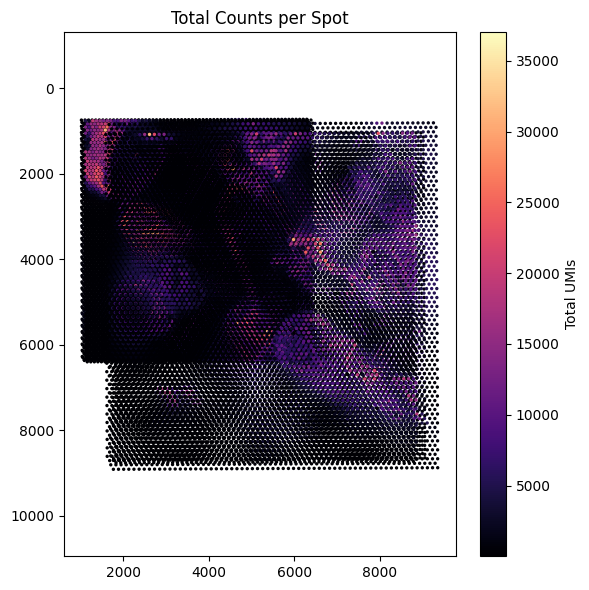

In [34]:
# Re running scanpy 
import scanpy as sc
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Scatterplot: total UMI counts per spot
plt.figure(figsize=(6, 6))
plt.scatter(
    coords[nonzero_mask][:, 0], coords[nonzero_mask][:, 1],
    c=adata.obs["total_counts"][nonzero_mask],
    cmap="magma", s=2
)
plt.gca().invert_yaxis()
plt.title("Total Counts per Spot")
plt.axis("equal")
plt.colorbar(label="Total UMIs")
plt.tight_layout()
plt.show()

### What are UMIs?
UMIs = Unique Molecular Identifiers
They are small random sequences added during library preparation to:

 `Distinguish true mRNA molecules from PCR duplicates`

So instead of saying "this gene has 10 reads," we say:

`This spot had 10 distinct mRNA molecules for that gene,` based on UMI tags.

### Why total UMI counts matter:
High UMI count = high transcriptional activity in that spot
- Could indicate dense cell areas (like cortex, tumor, neurons, etc.)

Low UMI count = potentially sparse or damaged tissue
- May be filtered out during quality control

[source](https://doi.org/10.1101/gr.209601.116)